In [1]:
%load_ext autoreload
%autoreload 2

# ESM1.6 Scaling

End-to-end pipeline generating scaling plots for ESM1.6 Pre-industrial configuration.

## Setup
The following variables control where the configurations and model run outputs are saved.

In [2]:
import os
import getpass
username = getpass.getuser()
defaultproject = os.environ.get("PROJECT")

# CHANGE test_path to where you're comfortable dumping model run information
test_path = f"/scratch/{defaultproject}/{username}/access_models_scaling_results"
# Name of the experiment
repository_directory = "esm1.6_PI_Concentrations"

## Generate experiments

We will perform a simple scaling study, varying the total number of nodes used from 1 to 4, that is, we will run the model with 52. 104, 208 and 416 cores.

In [3]:
from experiment_generator.experiment_generator import ExperimentGenerator

generator_config = {
    "model_type": "access-esm1.6",
    "repository_url": "https://github.com/ACCESS-NRI/access-esm1.6-configs.git",
    "start_point": "61b5e1c",
    "test_path": test_path,
    "repository_directory": repository_directory,
    "control_branch_name": "ctrl",
    "Control_Experiment": {
        "config.yaml": {
            "walltime": "10:0:0",
            "modules": {
                "use": [
                    "/g/data/vk83/modules",
                    "/g/data/tm70/ey7514/spack/0.22/release/modules/linux-rocky8-x86_64_v4",
                ],
                "load": ["cice5/access-esm1.6-bkvt77m", "access-esm1p6/2025.07.001"],
            },
            "manifest": {"reproduce": {"exe": False}},
        }
    },
    "Perturbation_Experiment": {
        "Parameter_block1": {
            "branches": ["1nodes", "2nodes", "4nodes", "8nodes"],
            "atmosphere/um_env.yaml": {
                "UM_ATM_NPROCX": ["4", "8", "16", "26"],
                "UM_ATM_NPROCY": ["13", "13", "13", "16"],
                "UM_NPES": ["52", "104", "208", "416"],
            },
            "ice/cice_in.nml": {"domain_nml": {"nprocs": [3, 6, 12, 24]}},
            "ocean/input.nml": {"ocean_model_nml": {"layout": ["7, 7", "14, 7", "14, 14", "28, 14"]}},
            "config.yaml": {
                "submodels": [
                    [
                        {
                            "name": "atmosphere",
                            "model": "um",
                            "ncpus": [52, 104, 208, 416],
                            "exe": "um_hg3.exe",
                            "input": [
                                [
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/OCFF_1850_cmip7.anc",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/BC_1850_cmip7.anc",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/scycl_1850_cmip7.anc",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/pre-industrial/atmosphere/aerosol/global.N96/2025.06.04/Bio_1850_cmip7.anc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/biogenic_351sm.N96L38",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/sulpc_oxidants_N96_L38",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/aerosol/global.N96/2020.05.19/DMS_conc.N96",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/forcing/global.N96/2020.05.19/ozone_1850_ESM1.anc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/forcing/resolution_independent/2020.05.19/volcts_18502000ave.dat",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/land/biogeochemistry/global.N96/2020.05.19/Ndep_1850_ESM1.anc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/land/soiltype/global.N96/2020.05.19/qrparm.soil_igbp_vg",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/land/vegetation/global.N96/2020.05.19/cable_vegfunc_N96.anc",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/share/atmosphere/land/biogeochemistry/resolution_independent/2025.06.06/modis_phenology_csiro_nophase.txt",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/share/atmosphere/land/biogeochemistry/resolution_independent/2024.12.18/pftlookup_cable3.csv",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/land/biogeophysics/resolution_independent/2020.05.19/def_soil_params.txt",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/land/biogeophysics/resolution_independent/2020.05.19/def_veg_params.txt",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/spectral/resolution_independent/2020.05.19/spec3a_sw_hadgem1_6on",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/spectral/resolution_independent/2020.05.19/spec3a_lw_hadgem1_6on",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/grids/resolution_independent/2020.05.19/vertlevs_G3",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/share/atmosphere/stash/2020.05.19/",
                                ]
                            ],
                        },
                        {
                            "name": "ocean",
                            "model": "mom",
                            "ncpus": [49, 98, 196, 392],
                            "exe": "mom5_access_cm",
                            "input": [
                                [
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/biogeochemistry/global.1deg/2020.05.19/dust.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/biogeochemistry/global.1deg/2020.05.19/ocmip2_press_monthly_om1p5_bc.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/tides/global.1deg/2020.05.19/roughness_amp.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/ocean/tides/global.1deg/2020.05.19/tideamp.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/shortwave_penetration/global.1deg/2025.06.23/ssw_atten_depth.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/grid_spec.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/ocean_mosaic.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/mosaic/global.1deg/2025.07.29/ocean_hgrid.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/bathymetry/global.1deg/2025.07.29/topog.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ocean/grids/vertical/global.1deg/2025.07.29/ocean_vgrid.nc",
                                ]
                            ],
                        },
                        {
                            "name": "ice",
                            "model": "cice5",
                            "ncpus": [3, 6, 12, 24],
                            "exe": [
                                "cice_access-esm1.6_360x300_3x1_3p.exe",
                                "cice_access-esm1.6_360x300_6x1_6p.exe",
                                "cice_access-esm1.6_360x300_12x1_12p.exe",
                                "cice_access-esm1.6_360x300_24x1_24p.exe",
                            ],
                            "input": [
                                [
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ice/grids/global.1deg/2025.07.29/kmt.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/ice/grids/global.1deg/2025.07.29/grid.nc",
                                    "/g/data/vk83/prerelease/configurations/inputs/access-esm1p6/modern/share/ice/iceberg/global.1deg/2024.11.08/lice_discharge_iceberg.nc",
                                ]
                            ],
                        },
                        {
                            "name": "coupler",
                            "model": "oasis",
                            "ncpus": 0,
                            "input": [
                                [
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/grids/global.oi_1deg.a_N96/2025.07.29/grids.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/grids/global.oi_1deg.a_N96/2025.07.29/areas.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/coupler/grids/global.oi_1deg.a_N96/2020.05.19/masks.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1t_CONSERV_FRACNNEI.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1u_CONSERV_FRACNNEI.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_cice_to_um1v_CONSERV_FRACNNEI.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1t_to_cice_CONSERV_DESTAREA.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1t_to_cice_CONSERV_FRACNNEI.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1u_to_cice_CONSERV_FRACNNEI.nc",
                                    "/g/data/vk83/configurations/inputs/access-esm1p6/modern/share/coupler/remapping_weights/global.oi_1deg.a_N96/2025.08.06/rmp_um1v_to_cice_CONSERV_FRACNNEI.nc",
                                ]
                            ],
                        },
                    ]
                ]
            },
        }
    },
}

ExperimentGenerator(generator_config).run()

-- Test directory /scratch/tm70/mo1833/access_models_scaling_results already exists!
-- Test dir: /scratch/tm70/mo1833/access_models_scaling_results/esm1.6_PI_Concentrations already exists, hence not cloning https://github.com/ACCESS-NRI/access-esm1.6-configs.git
Checked out branch: ctrl
laboratory path:  /scratch/tm70/mo1833/access-esm
binary path:  /scratch/tm70/mo1833/access-esm/bin
input path:  /scratch/tm70/mo1833/access-esm/input
work path:  /scratch/tm70/mo1833/access-esm/work
archive path:  /scratch/tm70/mo1833/access-esm/archive
Found experiment archive: /scratch/tm70/mo1833/access-esm/archive/esm1.6_PI_Concentrations-ctrl-40f2b824
Removed archive symlink to /scratch/tm70/mo1833/access-esm/archive/esm1.6_PI_Concentrations-8nodes-db152a33
Added archive symlink to /scratch/tm70/mo1833/access-esm/archive/esm1.6_PI_Concentrations-ctrl-40f2b824
-- Branch 1nodes already exists, switching to it only!
Checked out branch: 1nodes
laboratory path:  /scratch/tm70/mo1833/access-esm
binary 

## Running the model

Next we create a runner config and run the experiments with `experiment-runner`.

In [4]:
from experiment_runner.experiment_runner import ExperimentRunner

runner_config = {
    "test_path": test_path,
    "repository_directory": repository_directory,
    # these branches need to match branches in the experiment generator config above.
    "running_branches": ["1nodes", "2nodes", "4nodes", "8nodes"],
    "keep_uuid": True,
    "nruns": [2, 2, 2, 2],
    "startfrom_restart": ["cold", "cold", "cold", "cold"],
}

# Run the experiment runner
ExperimentRunner(runner_config).run()

* Current Branch: 8nodes
    experiment_uuid: db152a33-236b-4cf6-9dbb-a3cad2ede070
Branch: 1nodes
    experiment_uuid: 21b80a12-2786-4e7b-9d8c-ed8b50bf8119
Branch: 2nodes
    experiment_uuid: 02944995-6a0c-4729-8e2d-50643e919716
Branch: 4nodes
    experiment_uuid: f529b059-d8b8-4aaf-ac4a-ed44f9a1f3c0
Branch: ctrl
    experiment_uuid: 40f2b824-7d0f-4d1b-8154-6e24666ab3a5
Branch: main
    No config file found
-- Test dir: /scratch/tm70/mo1833/access_models_scaling_results/1nodes/esm1.6_PI_Concentrations already exists, skipping cloning.
-- Repo 1nodes/esm1.6_PI_Concentrations is already up to date with 1nodes.
-- Test dir: /scratch/tm70/mo1833/access_models_scaling_results/2nodes/esm1.6_PI_Concentrations already exists, skipping cloning.
-- Repo 2nodes/esm1.6_PI_Concentrations is already up to date with 2nodes.
-- Test dir: /scratch/tm70/mo1833/access_models_scaling_results/4nodes/esm1.6_PI_Concentrations already exists, skipping cloning.
-- Repo 4nodes/esm1.6_PI_Concentrations is alread

## Parsing and plotting experiment results

We'll use the profiling parsers in access-profiling to do this.

In [5]:
# Start by processing FMS (MOM5) results
from access.profiling import FMSProfilingParser
from access.profiling import PayuJSONProfilingParser
fmsparser = FMSProfilingParser(has_hits=False)
payuparser = PayuJSONProfilingParser()

In [6]:
# Processing logs
from pathlib import Path
import glob

fmslogs = []
payulogs = []
for nnodes in (1, 2, 4, 8):
    archive_dir = f"{test_path}/{nnodes}nodes/esm1.6_PI_Concentrations/archive"
    with open(archive_dir + "/output000/access-esm1.6.out", "r") as f:
        fmslogs.append(f.read())
    payulog = glob.glob(archive_dir + "/payu_jobs/0/run/*.gadi-pbs.json")[0]
    with open(payulog, "r") as f:
        payulogs.append(f.read())

In [7]:
mom5_stats = fmsparser.parse_data_series(
    fmslogs,
    "ncpus",
    [104, 208, 416, 832]
)
mom5_stats

<xarray.Dataset> Size: 70kB
Dimensions:                                                              (
                                                                          ncpus: 4,
                                                                          region: 183)
Coordinates:
  * ncpus                                                                (ncpus) int64 32B ...
  * region                                                               (region) <U32 23kB ...
Data variables:
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058650>  (ncpus, region) float64 6kB [s] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058500>  (ncpus, region) float64 6kB [s] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058350>  (ncpus, region) float64 6kB [s] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058200>  (ncpus, region) float64 6kB [s] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058110>  (ncpus, region) float64 6kB [%] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a1a8c4a0>  (ncpus, region) int64 6kB [] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a8058440>  (ncpus, region) int64 6kB [] ...
    <access.profiling.metrics.ProfilingMetric object at 0x1486a80583e0>  (ncpus, region) int64 6kB [] ...

In [8]:
payu_stats = payuparser.parse_data_series(
    payulogs,
    "ncpus",
    [104, 208, 416, 832]
)
payu_stats.region

<xarray.DataArray 'region' (region: 5)> Size: 620B
array(['payu_setup_duration_seconds', 'payu_model_run_duration_seconds',
       'payu_run_duration_seconds', 'payu_archive_duration_seconds',
       'payu_total_duration_seconds'], dtype='<U31')
Coordinates:
  * region   (region) <U31 620B 'payu_setup_duration_seconds' ... 'payu_total...

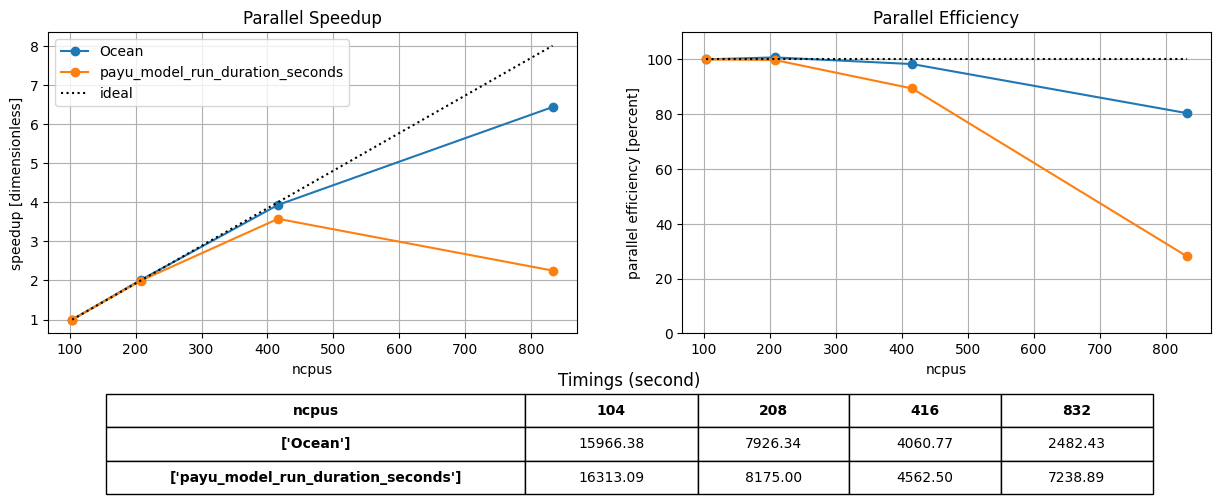

In [9]:
from access.profiling.scaling import plot_scaling_metrics
from access.profiling.metrics import tmax

# plots the Ocean region and tmax metric from the FMS stats, and 
# payu_model_run_duration_seconds region and walltime metric from payu stats.
plot_scaling_metrics(
    stats=[mom5_stats, payu_stats], 
    regions=[
        ["Ocean"], 
        ["payu_model_run_duration_seconds"]
    ], 
    metric=tmax,
)